In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from stefcal_uvdata import StefcalUVData
import stefcal_uvdata as suv
from data import DATA_PATH
import matplotlib.pyplot as plt

In this notebook, we test calibration of an MWA simulated visibility set. 

In [2]:
#initialize stefcal object 
stefcal_perfect=StefcalUVData()
complete_vis_path=os.path.join(DATA_PATH,
                               'mwa_complete_10ch/'
                               '2017-06-11-22-13-03/simdata/simvis-noiseless.uvfits')
complete_vis_noisy_path=os.path.join(DATA_PATH,
                                      'mwa_complete_10ch/'
                                      '2017-06-11-22-13-03/simdata/simvis-noisy.uvfits')
incomplete_vis_path=os.path.join(DATA_PATH,
                                 'mwa_incomplete_10ch/'
                                 '2017-06-12-00-41-12/simdata/simvis-noiseless.uvfits')
incomplete_vis_noisy_path=os.path.join(DATA_PATH,
                                       'mwa_incomplete_10ch/'
                                       '2017-06-12-00-41-12/simdata/simvis-noisy.uvfits')
#read in uvfits data and model files
stefcal_perfect.from_uvfits(complete_vis_path,complete_vis_path,
                           flag_weights_fromdata=True)    

stefcal_perfect.measured_vis.data_array=stefcal_perfect.measured_vis.data_array.astype('complex128')
stefcal_perfect.model_vis.data_array=stefcal_perfect.model_vis.data_array.astype('complex128')

#set calibration parameters
stefcal_perfect.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':1,
                           'n_phase_iter':5,
                           'refant':0,
                           't_avg':1})      
freqs=stefcal_perfect.measured_vis.freq_array
npol=stefcal_perfect.measured_vis.Npols
nant=stefcal_perfect.measured_vis.Nants_data

gains=np.ones_like(stefcal_perfect.uvcal.gain_array)
mean_amp=1e-1
std_amp=1e-2
amps=np.abs(np.random.randn(nant,npol)*std_amp+mean_amp)
mean_delay=200e-9
std_delay=10e-9
delays=np.abs(np.random.randn(nant,npol)*std_delay+mean_delay)
phases=np.random.rand(nant,npol)
for pol in range(npol):
    for ant in range(nant):
        d=delays[ant,pol].squeeze()
        a=amps[ant,pol].squeeze()
        p=phases[ant,pol].squeeze()
        gains[ant,0,:,0,pol]=1./(1.+a*np.exp(2j*np.pi*(freqs*d+p)))
#set the reference antenna phases to zero!
gains[0,0,:,0,:]=np.abs(gains[0,0,:,0,:])
test_gains=stefcal_perfect.uvcal_from_data()
test_gains.gain_array=gains
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains,applyGains=True)
stefcal_perfect.stefcalibrate()
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains)
gains_estimated=stefcal_perfect.uvcal.gain_array

boolean index did not match indexed array along dimension 0; dimension is 128 but corresponding boolean dimension is 1


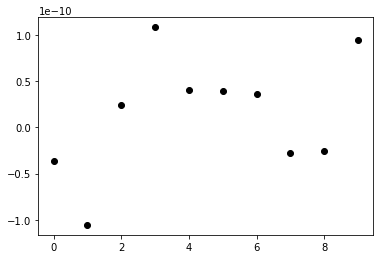

In [3]:
gains_estimated=stefcal_perfect.uvcal.gain_array
pol=0
for ant in range(1,2):
    plt.plot(np.imag(gains_estimated[ant,0,:,0,pol]-gains[ant,0,:,0,pol]),color='k',marker='o',ls='none')

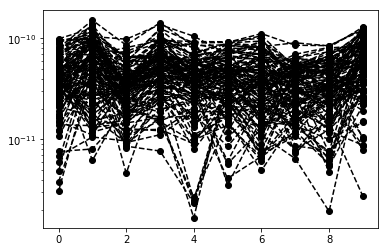

In [6]:
gains_estimated=stefcal_perfect.uvcal.gain_array
pol=0
for ant in range(128):
    plt.plot(np.abs(gains[ant,0,:,0,pol]-gains_estimated[ant,0,:,0,pol]),color='k',marker='o',ls='--')
plt.yscale('log')

In [5]:
np.any(np.abs(stefcal_perfect.model_vis.data_array\
    -stefcal_perfect.measured_vis.data_array)>=1e-13)

False

In [ ]:
stefcal_perfect.meta_params.Niterations